In [63]:
import tensorflow as tf
import numpy as np
from sklearn import datasets
import os
import matplotlib
matplotlib.use('Agg')

/home/kabir/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Loading and Visualizing the Dataset

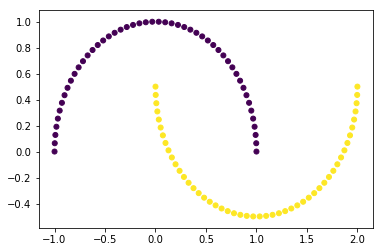

In [2]:
X,y = datasets.make_moons()
plt.scatter(X[:,0],X[:,1],marker = 'o',c = y,s = 25)
plt.show()

# Linear Classifier

In [39]:
def linear_model(learning_rate):
    tf.reset_default_graph()

    #placeholders to contain X and y while training
    input_placeholder = tf.placeholder(tf.float32,[None,2])
    output_placeholder = tf.placeholder(tf.int32,[None])
    
    #parameters for our linear classifier
    with tf.variable_scope('W'):
        W = tf.get_variable('W',shape = [2,2])
        b = tf.get_variable('b',shape = [2])
        
    logits = tf.matmul(input_placeholder,W) + b
    preds = tf.nn.softmax(logits)
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits, labels = output_placeholder))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    
    return dict(
        input_placeholder = input_placeholder,
        output_placeholder = output_placeholder,
        W = W,
        b = b,
        loss = loss,
        preds = preds,
        saver = tf.train.Saver(),
        optimizer = optimizer,
    )
    

In [69]:
def train(g,X,y):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints1/'))
        if ckpt and ckpt.model_checkpoint_path:
            g['saver'].restore(sess, ckpt.model_checkpoint_path)
        losses = []
        feed_dict = {g['input_placeholder']:X,g['output_placeholder']:y}
        for i in range(1000):   
            _,total_loss = sess.run([g['optimizer'],g['loss']],feed_dict)
            losses.append(total_loss)
            if i%100==0:
                g['saver'].save(sess,'checkpoints1/itr'+str(i))
                print('itr '+str(i)+":", total_loss)
        return losses

In [41]:
g = linear_model(0.05)

In [42]:
lc_losses = train(g,X,y)

itr 0: 1.67338
itr 100: 0.432523
itr 200: 0.329387
itr 300: 0.304876
itr 400: 0.29324
itr 500: 0.285934
itr 600: 0.280756
itr 700: 0.27687
itr 800: 0.273858
itr 900: 0.271478


In [140]:
def model_predict(g,X,checkpoint):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        ckpt = tf.train.get_checkpoint_state(os.path.dirname(checkpoint))
        g['saver'].restore(sess, ckpt.model_checkpoint_path)
        predictions = sess.run(g['preds'],{g['input_placeholder']:X})
        predictions = np.argmax(predictions,1)
    return predictions

In [143]:
def plot_decision_boundary(g,X,checkpoint,h=0.01):
    # X - some data in 2dimensional np.array

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

    # here "model" is your model's prediction (classification) function
    Z = model_predict(g,np.c_[xx.ravel(), yy.ravel()],checkpoint) 

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z,  cmap=plt.cm.Spectral)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], marker = 'o',c = y,s = 15, cmap=plt.cm.Paired)
    plt.savefig('myfig')
    plt.show()


INFO:tensorflow:Restoring parameters from checkpoints1/itr900


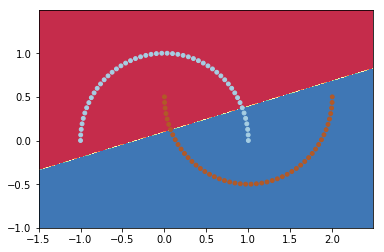

In [66]:
plot_decision_boundary(X)

# Neural Networks

In [75]:
def neural_model(learning_rate = 0.01):
    tf.reset_default_graph()
    
    input_placeholder = tf.placeholder(tf.float32,[None,2])
    output_placeholder = tf.placeholder(tf.int32,[None])
    
    with tf.variable_scope('W1'):
        W1 = tf.get_variable('W1',shape=[2,5],initializer=tf.truncated_normal_initializer())
        b1 = tf.get_variable('b1',shape = [5],initializer = tf.constant_initializer(0.0))
    a1 = tf.matmul(input_placeholder,W1) + b1
    h1 = tf.nn.relu(a1)
    with tf.variable_scope('W2'):
        W2 = tf.get_variable('W2',shape=[5,2],initializer=tf.truncated_normal_initializer())
        b2 = tf.get_variable('b2',shape = [2],initializer = tf.constant_initializer(0.0))
    a2 = tf.matmul(h1,W2) + b2
    h2 = tf.nn.relu(a2)
    with tf.variable_scope('W3'):
        W3 = tf.get_variable('W3',shape=[2,2],initializer=tf.truncated_normal_initializer())
        b3 = tf.get_variable('b3',shape = [2],initializer = tf.constant_initializer(0.0))
    logits = tf.matmul(h2,W3) + b3
    preds = tf.nn.softmax(logits)
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits, labels = output_placeholder))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    return dict(
    input_placeholder = input_placeholder,
    output_placeholder = output_placeholder,
    loss = loss,
    preds = preds,
    saver = tf.train.Saver(),
    optimizer = optimizer,
    h2 = h2
    )

In [103]:
def train_neural(g,X,y):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints2/'))
        if ckpt and ckpt.model_checkpoint_path:
            g['saver'].restore(sess, ckpt.model_checkpoint_path)
        losses = []
        feed_dict = {g['input_placeholder']:X,g['output_placeholder']:y}
        for i in range(40000):   
            _,total_loss = sess.run([g['optimizer'],g['loss']],feed_dict)
            losses.append(total_loss)
            if i%1000==0:
                g['saver'].save(sess,'checkpoints2/itr'+str(i))
                print('itr '+str(i)+":", total_loss)
        hid2 = sess.run(g['h2'],{g['input_placeholder']:X})        
        return hid2,losses

In [104]:
g = neural_model()

In [105]:
hid2,losses_neural = train_neural(g,X,y)

INFO:tensorflow:Restoring parameters from checkpoints2/itr19000
itr 0: 0.000546728
itr 1000: 0.000542359
itr 2000: 0.000537969
itr 3000: 0.000533706
itr 4000: 0.000529462
itr 5000: 0.000525356
itr 6000: 0.000521209
itr 7000: 0.000517148
itr 8000: 0.000513197
itr 9000: 0.000509377
itr 10000: 0.000505565
itr 11000: 0.000501827
itr 12000: 0.000498109
itr 13000: 0.000494413
itr 14000: 0.000490781
itr 15000: 0.00048715
itr 16000: 0.00048359
itr 17000: 0.000479969
itr 18000: 0.000476529
itr 19000: 0.000473163
itr 20000: 0.000469879
itr 21000: 0.000466596
itr 22000: 0.000463323
itr 23000: 0.000460189
itr 24000: 0.000457
itr 25000: 0.000453941
itr 26000: 0.000450845
itr 27000: 0.000447754
itr 28000: 0.00044475
itr 29000: 0.000441805
itr 30000: 0.00043897
itr 31000: 0.000436196
itr 32000: 0.00043337
itr 33000: 0.00043061
itr 34000: 0.000427851
itr 35000: 0.000425157
itr 36000: 0.000422408
itr 37000: 0.000419724
itr 38000: 0.000417039
itr 39000: 0.000414364


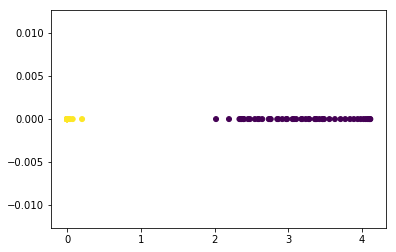

In [106]:
plt.scatter(hid2[:,0],hid2[:,1],marker = 'o',c = y,s = 25)
plt.show()

# Visualizing Decision Boundaries learned by Neural Nets

In [153]:
def neural_model_db(learning_rate = 0.01,n=5):
    tf.reset_default_graph()
    
    input_placeholder = tf.placeholder(tf.float32,[None,2])
    output_placeholder = tf.placeholder(tf.int32,[None])
    
    with tf.variable_scope('W1'):
        W1 = tf.get_variable('W1',shape=[2,n],initializer=tf.truncated_normal_initializer())
        b1 = tf.get_variable('b1',shape = [n],initializer = tf.constant_initializer(0.0))
    a1 = tf.matmul(input_placeholder,W1) + b1
    h1 = tf.nn.relu(a1)
    with tf.variable_scope('W2'):
        W2 = tf.get_variable('W2',shape=[n,2],initializer=tf.truncated_normal_initializer())
        b2 = tf.get_variable('b2',shape = [2],initializer = tf.constant_initializer(0.0))
    logits = tf.matmul(h1,W2) + b2
    preds = tf.nn.softmax(logits)
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits, labels = output_placeholder))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    return dict(
    input_placeholder = input_placeholder,
    output_placeholder = output_placeholder,
    loss = loss,
    preds = preds,
    saver = tf.train.Saver(),
    optimizer = optimizer
    )

In [154]:
def train_neural_db(g,X,y):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints3/'))
        if ckpt and ckpt.model_checkpoint_path:
            g['saver'].restore(sess, ckpt.model_checkpoint_path)
        losses = []
        feed_dict = {g['input_placeholder']:X,g['output_placeholder']:y}
        for i in range(90000):   
            _,total_loss = sess.run([g['optimizer'],g['loss']],feed_dict)
            losses.append(total_loss)
            if i%1000==0:
                g['saver'].save(sess,'checkpoints3/itr'+str(i))
                print('itr '+str(i)+":", total_loss)
        return losses

In [155]:
g1 = neural_model_db(0.01,15)

In [157]:
losses = train_neural_db(g1,X,y)

itr 0: 1.35445
itr 1000: 0.298054
itr 2000: 0.260807
itr 3000: 0.244762
itr 4000: 0.235637
itr 5000: 0.229495
itr 6000: 0.222844
itr 7000: 0.216618
itr 8000: 0.208871
itr 9000: 0.198361
itr 10000: 0.18412
itr 11000: 0.166097
itr 12000: 0.144758
itr 13000: 0.122841
itr 14000: 0.102571
itr 15000: 0.0853191
itr 16000: 0.0716175
itr 17000: 0.0605904
itr 18000: 0.0520068
itr 19000: 0.0451061
itr 20000: 0.0395444
itr 21000: 0.0350283
itr 22000: 0.0313031
itr 23000: 0.0281789
itr 24000: 0.0255072
itr 25000: 0.0232477
itr 26000: 0.0213119
itr 27000: 0.0196389
itr 28000: 0.0181826
itr 29000: 0.0169125
itr 30000: 0.0157963
itr 31000: 0.0148063
itr 32000: 0.0139229
itr 33000: 0.0131304
itr 34000: 0.0124155
itr 35000: 0.011768
itr 36000: 0.0111793
itr 37000: 0.0106434
itr 38000: 0.0101533
itr 39000: 0.00970275
itr 40000: 0.00928757
itr 41000: 0.00890375
itr 42000: 0.00854785
itr 43000: 0.00821728
itr 44000: 0.00790328
itr 45000: 0.00760398
itr 46000: 0.00732514
itr 47000: 0.00706521
itr 48000: 0.0

INFO:tensorflow:Restoring parameters from checkpoints3/itr89000


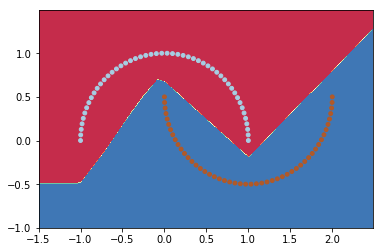

In [158]:
plot_decision_boundary(g1,X,'checkpoints3/',h=0.01)

In [159]:
g2 = neural_model_db(0.01,10)

In [161]:
losses = train_neural_db(g2,X,y)

itr 0: 0.670127
itr 1000: 0.257899
itr 2000: 0.21865
itr 3000: 0.1924
itr 4000: 0.167823
itr 5000: 0.144273
itr 6000: 0.122318
itr 7000: 0.102685
itr 8000: 0.0860541
itr 9000: 0.0722417
itr 10000: 0.0611999
itr 11000: 0.0520385
itr 12000: 0.044907
itr 13000: 0.0390918
itr 14000: 0.0343651
itr 15000: 0.0305531
itr 16000: 0.0273551
itr 17000: 0.0246634
itr 18000: 0.0223811
itr 19000: 0.020419
itr 20000: 0.0187621
itr 21000: 0.0173097
itr 22000: 0.0160463
itr 23000: 0.0149373


KeyboardInterrupt: 

INFO:tensorflow:Restoring parameters from checkpoints3/itr23000


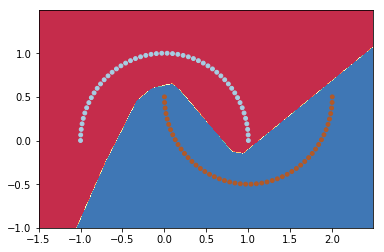

In [162]:
plot_decision_boundary(g2,X,'checkpoints3/',h=0.01)

In [165]:
g3 = neural_model_db(0.01,5)

In [166]:
losses = train_neural_db(g3,X,y)

itr 0: 1.66488
itr 1000: 0.431141
itr 2000: 0.346862
itr 3000: 0.279537
itr 4000: 0.232797
itr 5000: 0.212183
itr 6000: 0.195343
itr 7000: 0.177251
itr 8000: 0.156984
itr 9000: 0.136983
itr 10000: 0.117759
itr 11000: 0.0998477
itr 12000: 0.0847601
itr 13000: 0.0720754
itr 14000: 0.0613009
itr 15000: 0.0527817
itr 16000: 0.0457622
itr 17000: 0.0403401
itr 18000: 0.035429
itr 19000: 0.0315745
itr 20000: 0.0285071
itr 21000: 0.0256351
itr 22000: 0.0231921
itr 23000: 0.0212255
itr 24000: 0.0195955
itr 25000: 0.0181955
itr 26000: 0.0169769
itr 27000: 0.0159067
itr 28000: 0.0148788
itr 29000: 0.0138751
itr 30000: 0.0130116
itr 31000: 0.0122667
itr 32000: 0.0116057
itr 33000: 0.0110135
itr 34000: 0.0104785
itr 35000: 0.0099922
itr 36000: 0.0095479
itr 37000: 0.00914043
itr 38000: 0.00876521
itr 39000: 0.00841856
itr 40000: 0.00809753
itr 41000: 0.00779924
itr 42000: 0.00752142
itr 43000: 0.00726198
itr 44000: 0.00701921
itr 45000: 0.00679152
itr 46000: 0.00652004
itr 47000: 0.00629479
itr 480

KeyboardInterrupt: 

INFO:tensorflow:Restoring parameters from checkpoints3/itr85000


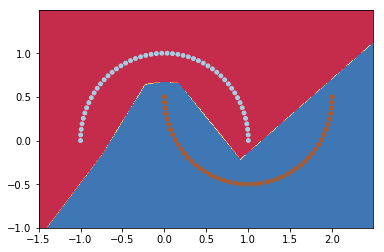

In [167]:
plot_decision_boundary(g3,X,'checkpoints3/',h=0.01)

In [171]:
g4 = neural_model_db(0.01,4)

In [172]:
losses = train_neural_db(g4,X,y)

itr 0: 0.734345
itr 1000: 0.277504
itr 2000: 0.247183
itr 3000: 0.230616
itr 4000: 0.217265
itr 5000: 0.203477
itr 6000: 0.188576
itr 7000: 0.172083
itr 8000: 0.153826
itr 9000: 0.135253
itr 10000: 0.116672
itr 11000: 0.099314
itr 12000: 0.0841096
itr 13000: 0.0714789
itr 14000: 0.0607632
itr 15000: 0.052212
itr 16000: 0.0452802
itr 17000: 0.0397853
itr 18000: 0.0352626
itr 19000: 0.0314127
itr 20000: 0.0282395
itr 21000: 0.0256103
itr 22000: 0.0234134
itr 23000: 0.0214047
itr 24000: 0.0196804
itr 25000: 0.0181956
itr 26000: 0.016904
itr 27000: 0.0157838
itr 28000: 0.0147977
itr 29000: 0.0139198
itr 30000: 0.0131335
itr 31000: 0.0124256
itr 32000: 0.0117853
itr 33000: 0.0112036
itr 34000: 0.0106731
itr 35000: 0.010167
itr 36000: 0.00968815
itr 37000: 0.00924964
itr 38000: 0.00884696
itr 39000: 0.00847584
itr 40000: 0.00813743
itr 41000: 0.0078238
itr 42000: 0.00753223
itr 43000: 0.00726032
itr 44000: 0.00700624
itr 45000: 0.00676847
itr 46000: 0.00654554
itr 47000: 0.00633608
itr 48000

INFO:tensorflow:Restoring parameters from checkpoints3/itr89000


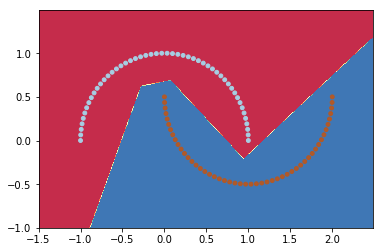

In [173]:
plot_decision_boundary(g4,X,'checkpoints3/',h=0.01)

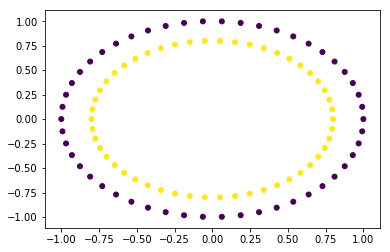

In [174]:
#Lets try some other dataset
X,y = datasets.make_circles()
plt.scatter(X[:,0],X[:,1],marker = 'o',c = y,s = 25)
plt.show()

In [175]:
g5 = neural_model_db(0.01,5)

In [176]:
losses = train_neural_db(g5,X,y)

itr 0: 1.16756
itr 1000: 0.62252
itr 2000: 0.590999
itr 3000: 0.558355
itr 4000: 0.525433
itr 5000: 0.492327
itr 6000: 0.458509
itr 7000: 0.423481
itr 8000: 0.38461
itr 9000: 0.344311
itr 10000: 0.30704
itr 11000: 0.272427
itr 12000: 0.240518
itr 13000: 0.21053
itr 14000: 0.185481
itr 15000: 0.164088
itr 16000: 0.145851
itr 17000: 0.130308
itr 18000: 0.117037
itr 19000: 0.105672
itr 20000: 0.0959006
itr 21000: 0.0874619
itr 22000: 0.08014
itr 23000: 0.0737623
itr 24000: 0.0681725
itr 25000: 0.0632475
itr 26000: 0.0588871
itr 27000: 0.0550085
itr 28000: 0.0515428
itr 29000: 0.0484337
itr 30000: 0.0456327
itr 31000: 0.0431
itr 32000: 0.0408015
itr 33000: 0.0387084
itr 34000: 0.0367962
itr 35000: 0.0350442
itr 36000: 0.0334342
itr 37000: 0.0319504
itr 38000: 0.0305797
itr 39000: 0.0293102
itr 40000: 0.0281319
itr 41000: 0.0270355
itr 42000: 0.0260137
itr 43000: 0.0250592
itr 44000: 0.0241658
itr 45000: 0.0233283
itr 46000: 0.0225418
itr 47000: 0.0218019
itr 48000: 0.0211049
itr 49000: 0.0

INFO:tensorflow:Restoring parameters from checkpoints3/itr89000


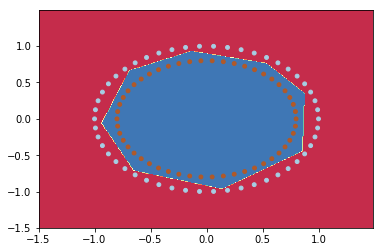

In [178]:
plot_decision_boundary(g5,X,'checkpoints3/',h=0.01)

In [179]:
g5 = neural_model_db(0.01,15)

In [181]:
losses = train_neural_db(g5,X,y)

itr 0: 0.798665
itr 1000: 0.576938
itr 2000: 0.502887
itr 3000: 0.433449
itr 4000: 0.368174
itr 5000: 0.309413
itr 6000: 0.259038
itr 7000: 0.216358
itr 8000: 0.18148
itr 9000: 0.153308
itr 10000: 0.130747
itr 11000: 0.112161
itr 12000: 0.0972411
itr 13000: 0.0840885
itr 14000: 0.0737567
itr 15000: 0.0653917
itr 16000: 0.0585252
itr 17000: 0.052751
itr 18000: 0.047864
itr 19000: 0.0436808
itr 20000: 0.0400693
itr 21000: 0.0369289
itr 22000: 0.0341798
itr 23000: 0.0317559
itr 24000: 0.0296085
itr 25000: 0.0276967
itr 26000: 0.0259862
itr 27000: 0.0244393
itr 28000: 0.0230367
itr 29000: 0.021769
itr 30000: 0.020618
itr 31000: 0.0195695
itr 32000: 0.0186111
itr 33000: 0.0177319
itr 34000: 0.0169225
itr 35000: 0.0161756
itr 36000: 0.0154846
itr 37000: 0.014844
itr 38000: 0.0142485
itr 39000: 0.013694
itr 40000: 0.0131764
itr 41000: 0.0126924
itr 42000: 0.012239
itr 43000: 0.0118134
itr 44000: 0.0114131
itr 45000: 0.011032
itr 46000: 0.0106737
itr 47000: 0.0103359
itr 48000: 0.0100172
itr 4

INFO:tensorflow:Restoring parameters from checkpoints3/itr89000


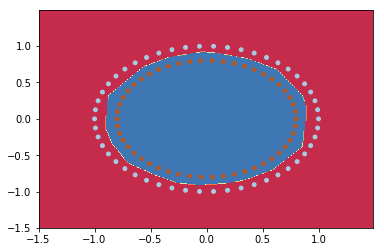

In [182]:
plot_decision_boundary(g5,X,'checkpoints3/',h=0.01)

In [183]:
g5 = neural_model_db(0.01,30)

In [184]:
losses = train_neural_db(g5,X,y)

itr 0: 1.67147
itr 1000: 0.561821
itr 2000: 0.436867
itr 3000: 0.335019
itr 4000: 0.270136
itr 5000: 0.219358
itr 6000: 0.178294
itr 7000: 0.147368
itr 8000: 0.12351
itr 9000: 0.104759
itr 10000: 0.0897268
itr 11000: 0.0769462
itr 12000: 0.0673967
itr 13000: 0.0599049
itr 14000: 0.0536861
itr 15000: 0.0484624
itr 16000: 0.0440179
itr 17000: 0.0402091
itr 18000: 0.0369151
itr 19000: 0.0340446
itr 20000: 0.0315352
itr 21000: 0.0293187
itr 22000: 0.0273488
itr 23000: 0.0255873
itr 24000: 0.0240137
itr 25000: 0.0226007
itr 26000: 0.0213285
itr 27000: 0.0201751
itr 28000: 0.0191284
itr 29000: 0.0181726
itr 30000: 0.0172988
itr 31000: 0.0164967
itr 32000: 0.015758
itr 33000: 0.0150761
itr 34000: 0.0144445
itr 35000: 0.013858
itr 36000: 0.0133122
itr 37000: 0.0128031
itr 38000: 0.0123241
itr 39000: 0.0118725
itr 40000: 0.0114499
itr 41000: 0.0110537
itr 42000: 0.0106814
itr 43000: 0.0103312
itr 44000: 0.0100009
itr 45000: 0.00968916
itr 46000: 0.00939438
itr 47000: 0.00911529
itr 48000: 0.008

INFO:tensorflow:Restoring parameters from checkpoints3/itr89000


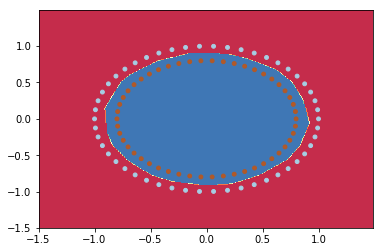

In [185]:
plot_decision_boundary(g5,X,'checkpoints3/',h=0.01)